In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Convolution1D, MaxPooling1D, LSTM
from keras.layers import Input, Conv1D, MaxPool1D, Bidirectional, GRU
from keras.layers.merge import concatenate
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [2]:
# DATASET
#DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "https?:\S+|http?:\S"

# WORD2VEC 
W2V_SIZE = 200
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 5

# KERAS
SEQUENCE_LENGTH = 50
EPOCHS = 32
BATCH_SIZE = 256

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [3]:
# read dataset
dataset_filename = os.listdir("./data")[0]
dataset_path = os.path.join(".","data","cong_politician_tweets.csv")
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding ="ISO-8859-1")
#print(df.head(5))

Open file: .\data\cong_politician_tweets.csv


C:\Users\Lingshu\.conda\envs\my_env\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (17,62,63,64,65,66,67,96) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [127]:
df = pd.read_csv("./data/cong_politician_tweets30000.csv", encoding = "ISO-8859-1")

C:\Users\Lingshu\.conda\envs\my_env\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,7,11,12,18,77,78,79,80,81,84,87) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
df['party'] = df['party'].map({'D':0, 'R':1})

In [262]:
df.party[1]

0

Text(0.5, 1.0, 'Dataset labels distribuition')

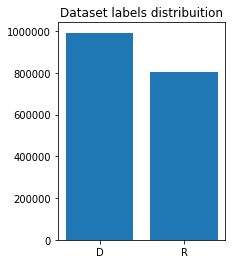

In [173]:
target_cnt = Counter(df.party)

plt.figure(figsize=(3,4))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

Pre-Process dataset

In [4]:
## do not remove stop words

def preprocess(text, stem=False):
    # Remove link
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    text = re.sub(r"@", "@ ", text)
    text = re.sub(r"#", "# ", text)
    return(text)

In [5]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 8.08 s


In [13]:
df.text

0          iâve lived with stage 4 endometriosis for ye...
1          "to be a woman, talking about what disadvantag...
2          <u+2764><u+fe0f> heâs my best friend and weâ...
3          1 in 10 women suffer from endometriosis.\r\n\r...
4          good morning to @ abby4iowa who's inspiring me...
                                 ...                        
1796931    mt @ vkritzer: i'm proud to have helped elect ...
1796932    to help in the fight to end the # nsa's mass s...
1796933    here's becca in the stadium waiting for the ra...
1796934    happy 21st anniversary to the # fmla! by helpi...
1796935    marshawn lynch is sitting on the hood of the f...
Name: text, Length: 1796936, dtype: object

In [7]:
df = df[df.party.notna()]

Split train and test

In [8]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1437548
TEST size: 359388


Word2Vec

In [3]:
w2v_model = gensim.models.Word2Vec.load("model.w2v")

2020-04-03 00:16:52,052 : INFO : loading Word2Vec object from model.w2v
2020-04-03 00:16:52,502 : INFO : loading wv recursively from model.w2v.wv.* with mmap=None
2020-04-03 00:16:52,502 : INFO : loading vectors from model.w2v.wv.vectors.npy with mmap=None
2020-04-03 00:16:53,243 : INFO : setting ignored attribute vectors_norm to None
2020-04-03 00:16:53,243 : INFO : loading vocabulary recursively from model.w2v.vocabulary.* with mmap=None
2020-04-03 00:16:53,243 : INFO : loading trainables recursively from model.w2v.trainables.* with mmap=None
2020-04-03 00:16:53,243 : INFO : loading syn1neg from model.w2v.trainables.syn1neg.npy with mmap=None
2020-04-03 00:16:53,979 : INFO : setting ignored attribute cum_table to None
2020-04-03 00:16:53,979 : INFO : loaded model.w2v


In [62]:
%%time
## this one works better
documents = [_text.split() for _text in df.text] ## what's the purpose here?
print(documents[0])

['I’ve', 'lived', 'with', 'Stage', '4', 'endometriosis', 'for', 'years,', 'and', 'I’m', 'so', 'proud', 'of', '@', 'Abby4Iowa', 'for', 'sharing', 'her', 'story.', 'We', 'stand', 'together', 'with', '@', 'endofound', 'to', 'call', 'for', 'more', 'research', 'on', 'the', 'disease', 'that', 'affect', '1', 'in', '10', 'woman', '&amp;', 'cost', 'our', 'country', '$78', 'billion', 'a', 'year.', '#', 'UpEndo']
Wall time: 11.1 s


In [61]:
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()
documents = [tweet_tokenizer.tokenize(str(sent)) for sent in df_train.text]

print(documents[0:10])

KeyboardInterrupt: 

In [63]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [64]:
w2v_model.build_vocab(documents)

2020-03-31 21:53:39,293 : INFO : collecting all words and their counts
2020-03-31 21:53:39,293 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-03-31 21:53:39,340 : INFO : PROGRESS: at sentence #10000, processed 274513 words, keeping 31949 word types
2020-03-31 21:53:39,387 : INFO : PROGRESS: at sentence #20000, processed 506641 words, keeping 47665 word types
2020-03-31 21:53:39,437 : INFO : PROGRESS: at sentence #30000, processed 757971 words, keeping 62458 word types
2020-03-31 21:53:39,495 : INFO : PROGRESS: at sentence #40000, processed 1030090 words, keeping 77192 word types
2020-03-31 21:53:39,555 : INFO : PROGRESS: at sentence #50000, processed 1290244 words, keeping 89807 word types
2020-03-31 21:53:39,601 : INFO : PROGRESS: at sentence #60000, processed 1557779 words, keeping 101064 word types
2020-03-31 21:53:39,642 : INFO : PROGRESS: at sentence #70000, processed 1780992 words, keeping 110795 word types
2020-03-31 21:53:39,709 : INFO : PROGRES

2020-03-31 21:53:43,012 : INFO : PROGRESS: at sentence #710000, processed 17644605 words, keeping 525157 word types
2020-03-31 21:53:43,059 : INFO : PROGRESS: at sentence #720000, processed 17913697 words, keeping 528798 word types
2020-03-31 21:53:43,118 : INFO : PROGRESS: at sentence #730000, processed 18186806 words, keeping 533871 word types
2020-03-31 21:53:43,162 : INFO : PROGRESS: at sentence #740000, processed 18460455 words, keeping 538221 word types
2020-03-31 21:53:43,217 : INFO : PROGRESS: at sentence #750000, processed 18675956 words, keeping 544678 word types
2020-03-31 21:53:43,261 : INFO : PROGRESS: at sentence #760000, processed 18907663 words, keeping 551466 word types
2020-03-31 21:53:43,318 : INFO : PROGRESS: at sentence #770000, processed 19160964 words, keeping 556551 word types
2020-03-31 21:53:43,378 : INFO : PROGRESS: at sentence #780000, processed 19453162 words, keeping 562643 word types
2020-03-31 21:53:43,425 : INFO : PROGRESS: at sentence #790000, processe

2020-03-31 21:53:46,687 : INFO : PROGRESS: at sentence #1420000, processed 35677247 words, keeping 837272 word types
2020-03-31 21:53:46,741 : INFO : PROGRESS: at sentence #1430000, processed 35916762 words, keeping 840786 word types
2020-03-31 21:53:46,780 : INFO : PROGRESS: at sentence #1440000, processed 36150319 words, keeping 844017 word types
2020-03-31 21:53:46,841 : INFO : PROGRESS: at sentence #1450000, processed 36391880 words, keeping 848298 word types
2020-03-31 21:53:46,888 : INFO : PROGRESS: at sentence #1460000, processed 36631607 words, keeping 852074 word types
2020-03-31 21:53:46,935 : INFO : PROGRESS: at sentence #1470000, processed 36861489 words, keeping 856851 word types
2020-03-31 21:53:46,982 : INFO : PROGRESS: at sentence #1480000, processed 37126344 words, keeping 861133 word types
2020-03-31 21:53:47,030 : INFO : PROGRESS: at sentence #1490000, processed 37390470 words, keeping 865177 word types
2020-03-31 21:53:47,091 : INFO : PROGRESS: at sentence #1500000,

In [65]:
words_w = w2v_model.wv.vocab.keys()
#print(len(w2v_model.wv["u"]))
#print(list(w2v_model.wv.vocab.items())[0:5])
vocab_size = len(words_w)
print("Vocab size", vocab_size)

Vocab size 178058


In [66]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH) ##?

2020-03-31 21:55:37,506 : INFO : training model with 8 workers on 178058 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-03-31 21:55:39,056 : INFO : EPOCH 1 - PROGRESS: at 2.59% examples, 923722 words/s, in_qsize 14, out_qsize 1
2020-03-31 21:55:40,085 : INFO : EPOCH 1 - PROGRESS: at 6.00% examples, 1052529 words/s, in_qsize 13, out_qsize 2
2020-03-31 21:55:41,087 : INFO : EPOCH 1 - PROGRESS: at 9.37% examples, 1093881 words/s, in_qsize 16, out_qsize 0
2020-03-31 21:55:42,117 : INFO : EPOCH 1 - PROGRESS: at 12.93% examples, 1110449 words/s, in_qsize 13, out_qsize 2
2020-03-31 21:55:43,132 : INFO : EPOCH 1 - PROGRESS: at 16.58% examples, 1133137 words/s, in_qsize 15, out_qsize 0
2020-03-31 21:55:44,134 : INFO : EPOCH 1 - PROGRESS: at 19.94% examples, 1143586 words/s, in_qsize 15, out_qsize 0
2020-03-31 21:55:45,143 : INFO : EPOCH 1 - PROGRESS: at 23.72% examples, 1152006 words/s, in_qsize 15, out_qsize 0
2020-03-31 21:55:46,149 : INFO : EPOCH 1 - PROGR

2020-03-31 21:56:37,167 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-31 21:56:37,171 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-31 21:56:37,171 : INFO : EPOCH - 2 : training on 44832010 raw words (34709765 effective words) took 29.4s, 1182583 effective words/s
2020-03-31 21:56:38,189 : INFO : EPOCH 3 - PROGRESS: at 3.32% examples, 1179249 words/s, in_qsize 13, out_qsize 2
2020-03-31 21:56:39,216 : INFO : EPOCH 3 - PROGRESS: at 7.04% examples, 1207360 words/s, in_qsize 11, out_qsize 4
2020-03-31 21:56:40,224 : INFO : EPOCH 3 - PROGRESS: at 10.34% examples, 1197387 words/s, in_qsize 14, out_qsize 1
2020-03-31 21:56:41,226 : INFO : EPOCH 3 - PROGRESS: at 13.93% examples, 1193273 words/s, in_qsize 15, out_qsize 0
2020-03-31 21:56:42,256 : INFO : EPOCH 3 - PROGRESS: at 17.43% examples, 1190057 words/s, in_qsize 15, out_qsize 0
2020-03-31 21:56:43,257 : INFO : EPOCH 3 - PROGRESS: at 20.90% examples, 1191476 words/s, in_qsize 14, o

2020-03-31 21:57:35,467 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-31 21:57:35,467 : INFO : EPOCH - 4 : training on 44832010 raw words (34710098 effective words) took 29.0s, 1197633 effective words/s
2020-03-31 21:57:36,476 : INFO : EPOCH 5 - PROGRESS: at 3.38% examples, 1211296 words/s, in_qsize 15, out_qsize 0
2020-03-31 21:57:37,498 : INFO : EPOCH 5 - PROGRESS: at 6.84% examples, 1192363 words/s, in_qsize 15, out_qsize 0
2020-03-31 21:57:38,488 : INFO : EPOCH 5 - PROGRESS: at 10.30% examples, 1203005 words/s, in_qsize 15, out_qsize 0
2020-03-31 21:57:39,500 : INFO : EPOCH 5 - PROGRESS: at 13.86% examples, 1193697 words/s, in_qsize 13, out_qsize 2
2020-03-31 21:57:40,512 : INFO : EPOCH 5 - PROGRESS: at 17.36% examples, 1194648 words/s, in_qsize 14, out_qsize 1
2020-03-31 21:57:41,515 : INFO : EPOCH 5 - PROGRESS: at 20.79% examples, 1194075 words/s, in_qsize 15, out_qsize 0
2020-03-31 21:57:42,525 : INFO : EPOCH 5 - PROGRESS: at 24.39% examples, 1192313

2020-03-31 21:58:34,180 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-31 21:58:34,188 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-31 21:58:34,188 : INFO : EPOCH - 6 : training on 44832010 raw words (34707920 effective words) took 29.5s, 1176424 effective words/s
2020-03-31 21:58:35,192 : INFO : EPOCH 7 - PROGRESS: at 3.39% examples, 1220656 words/s, in_qsize 15, out_qsize 0
2020-03-31 21:58:36,200 : INFO : EPOCH 7 - PROGRESS: at 6.90% examples, 1206579 words/s, in_qsize 14, out_qsize 1
2020-03-31 21:58:37,211 : INFO : EPOCH 7 - PROGRESS: at 10.31% examples, 1203460 words/s, in_qsize 15, out_qsize 0
2020-03-31 21:58:38,214 : INFO : EPOCH 7 - PROGRESS: at 13.99% examples, 1206591 words/s, in_qsize 15, out_qsize 0
2020-03-31 21:58:39,239 : INFO : EPOCH 7 - PROGRESS: at 17.43% examples, 1197246 words/s, in_qsize 13, out_qsize 2
2020-03-31 21:58:40,250 : INFO : EPOCH 7 - PROGRESS: at 21.05% examples, 1204636 words/s, in_qsize 15, o

2020-03-31 21:59:33,005 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-31 21:59:33,009 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-31 21:59:33,009 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-31 21:59:33,021 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-31 21:59:33,021 : INFO : EPOCH - 8 : training on 44832010 raw words (34706511 effective words) took 29.4s, 1179923 effective words/s
2020-03-31 21:59:34,032 : INFO : EPOCH 9 - PROGRESS: at 3.37% examples, 1213345 words/s, in_qsize 14, out_qsize 1
2020-03-31 21:59:35,030 : INFO : EPOCH 9 - PROGRESS: at 6.93% examples, 1217923 words/s, in_qsize 13, out_qsize 2
2020-03-31 21:59:36,051 : INFO : EPOCH 9 - PROGRESS: at 10.38% examples, 1210706 words/s, in_qsize 12, out_qsize 3
2020-03-31 21:59:37,056 : INFO : EPOCH 9 - PROGRESS: at 14.02% examples, 1209612 words/s, in_qsize 14, out_qsize 1
2020-03-31 21:59:38,071 : INFO : EPOC

2020-03-31 22:00:32,554 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-31 22:00:32,554 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-31 22:00:32,565 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-31 22:00:32,565 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-31 22:00:32,565 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-31 22:00:32,573 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-31 22:00:32,573 : INFO : EPOCH - 10 : training on 44832010 raw words (34704198 effective words) took 29.8s, 1166172 effective words/s
2020-03-31 22:00:33,573 : INFO : EPOCH 11 - PROGRESS: at 3.25% examples, 1170952 words/s, in_qsize 14, out_qsize 1
2020-03-31 22:00:34,606 : INFO : EPOCH 11 - PROGRESS: at 6.76% examples, 1171319 words/s, in_qsize 15, out_qsize 0
2020-03-31 22:00:35,627 : INFO : EPOCH 11 - PROGRESS: at 10.18% examples, 1176040 

2020-03-31 22:01:31,060 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-03-31 22:01:31,092 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-03-31 22:01:31,107 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-31 22:01:31,114 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-31 22:01:31,118 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-31 22:01:31,122 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-31 22:01:31,126 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-31 22:01:31,130 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-31 22:01:31,130 : INFO : EPOCH - 12 : training on 44832010 raw words (34702426 effective words) took 29.3s, 1184564 effective words/s
2020-03-31 22:01:32,142 : INFO : EPOCH 13 - PROGRESS: at 3.43% examples, 1229333 words/s, in_qsize 14, out_qsize 1
2020-03-31 22:0

2020-03-31 22:02:29,400 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-03-31 22:02:29,400 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-03-31 22:02:29,400 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-31 22:02:29,411 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-31 22:02:29,411 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-31 22:02:29,415 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-31 22:02:29,415 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-31 22:02:29,421 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-31 22:02:29,421 : INFO : EPOCH - 14 : training on 44832010 raw words (34705883 effective words) took 29.2s, 1188092 effective words/s
2020-03-31 22:02:30,440 : INFO : EPOCH 15 - PROGRESS: at 3.38% examples, 1207527 words/s, in_qsize 15, out_qsize 0
2020-03-31 22:0

2020-03-31 22:03:27,663 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-03-31 22:03:27,678 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-03-31 22:03:27,685 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-31 22:03:27,694 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-31 22:03:27,694 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-31 22:03:27,694 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-31 22:03:27,703 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-31 22:03:27,703 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-31 22:03:27,703 : INFO : EPOCH - 16 : training on 44832010 raw words (34708092 effective words) took 29.2s, 1187515 effective words/s
2020-03-31 22:03:28,718 : INFO : EPOCH 17 - PROGRESS: at 3.40% examples, 1209157 words/s, in_qsize 14, out_qsize 1
2020-03-31 22:0

2020-03-31 22:04:25,946 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-03-31 22:04:25,962 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-03-31 22:04:25,966 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-31 22:04:25,966 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-31 22:04:25,971 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-31 22:04:25,974 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-31 22:04:25,978 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-31 22:04:25,978 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-31 22:04:25,978 : INFO : EPOCH - 18 : training on 44832010 raw words (34705032 effective words) took 29.2s, 1189813 effective words/s
2020-03-31 22:04:26,985 : INFO : EPOCH 19 - PROGRESS: at 3.26% examples, 1183779 words/s, in_qsize 16, out_qsize 0
2020-03-31 22:0

2020-03-31 22:05:24,412 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-03-31 22:05:24,433 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-03-31 22:05:24,433 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-31 22:05:24,433 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-31 22:05:24,433 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-31 22:05:24,439 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-31 22:05:24,439 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-31 22:05:24,455 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-31 22:05:24,455 : INFO : EPOCH - 20 : training on 44832010 raw words (34703823 effective words) took 29.2s, 1186514 effective words/s
2020-03-31 22:05:25,466 : INFO : EPOCH 21 - PROGRESS: at 3.36% examples, 1205811 words/s, in_qsize 15, out_qsize 0
2020-03-31 22:0

2020-03-31 22:06:22,898 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-03-31 22:06:22,924 : INFO : EPOCH 22 - PROGRESS: at 99.81% examples, 1187794 words/s, in_qsize 5, out_qsize 3
2020-03-31 22:06:22,940 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-03-31 22:06:22,944 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-31 22:06:22,944 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-31 22:06:22,957 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-31 22:06:22,957 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-31 22:06:22,957 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-31 22:06:22,963 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-31 22:06:22,963 : INFO : EPOCH - 22 : training on 44832010 raw words (34707346 effective words) took 29.2s, 1188173 effective words/s
2020-03-31 22:0

2020-03-31 22:07:20,393 : INFO : EPOCH 24 - PROGRESS: at 95.78% examples, 1183427 words/s, in_qsize 14, out_qsize 1
2020-03-31 22:07:21,410 : INFO : EPOCH 24 - PROGRESS: at 99.76% examples, 1183461 words/s, in_qsize 6, out_qsize 4
2020-03-31 22:07:21,410 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-03-31 22:07:21,443 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-03-31 22:07:21,443 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-31 22:07:21,455 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-31 22:07:21,455 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-31 22:07:21,459 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-31 22:07:21,472 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-31 22:07:21,475 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-31 22:07:21,476 : INFO : EPOCH - 

2020-03-31 22:08:17,716 : INFO : EPOCH 26 - PROGRESS: at 91.63% examples, 1181255 words/s, in_qsize 15, out_qsize 0
2020-03-31 22:08:18,733 : INFO : EPOCH 26 - PROGRESS: at 95.49% examples, 1182427 words/s, in_qsize 14, out_qsize 1
2020-03-31 22:08:19,732 : INFO : EPOCH 26 - PROGRESS: at 99.34% examples, 1182146 words/s, in_qsize 13, out_qsize 2
2020-03-31 22:08:19,832 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-03-31 22:08:19,855 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-03-31 22:08:19,870 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-31 22:08:19,882 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-31 22:08:19,890 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-31 22:08:19,894 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-31 22:08:19,894 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-31 22:0

2020-03-31 22:09:15,350 : INFO : EPOCH 28 - PROGRESS: at 88.80% examples, 1184410 words/s, in_qsize 15, out_qsize 0
2020-03-31 22:09:16,375 : INFO : EPOCH 28 - PROGRESS: at 92.28% examples, 1184934 words/s, in_qsize 13, out_qsize 2
2020-03-31 22:09:17,379 : INFO : EPOCH 28 - PROGRESS: at 95.96% examples, 1183707 words/s, in_qsize 14, out_qsize 1
2020-03-31 22:09:18,381 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-03-31 22:09:18,381 : INFO : EPOCH 28 - PROGRESS: at 99.84% examples, 1183211 words/s, in_qsize 3, out_qsize 7
2020-03-31 22:09:18,393 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-03-31 22:09:18,393 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-31 22:09:18,397 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-31 22:09:18,397 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-31 22:09:18,397 : INFO : worker thread finished; awaiting finish of 2 more

2020-03-31 22:10:11,836 : INFO : EPOCH 30 - PROGRESS: at 82.22% examples, 1185381 words/s, in_qsize 14, out_qsize 1
2020-03-31 22:10:12,859 : INFO : EPOCH 30 - PROGRESS: at 85.46% examples, 1185415 words/s, in_qsize 15, out_qsize 4
2020-03-31 22:10:13,856 : INFO : EPOCH 30 - PROGRESS: at 88.83% examples, 1186864 words/s, in_qsize 15, out_qsize 0
2020-03-31 22:10:14,859 : INFO : EPOCH 30 - PROGRESS: at 92.35% examples, 1188082 words/s, in_qsize 15, out_qsize 0
2020-03-31 22:10:15,870 : INFO : EPOCH 30 - PROGRESS: at 96.03% examples, 1186092 words/s, in_qsize 13, out_qsize 2
2020-03-31 22:10:16,821 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-03-31 22:10:16,853 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-03-31 22:10:16,867 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-31 22:10:16,872 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-31 22:10:16,879 : INFO : worker thread finished;

2020-03-31 22:11:09,271 : INFO : EPOCH 32 - PROGRESS: at 78.38% examples, 1184615 words/s, in_qsize 15, out_qsize 0
2020-03-31 22:11:10,281 : INFO : EPOCH 32 - PROGRESS: at 82.07% examples, 1184596 words/s, in_qsize 15, out_qsize 0
2020-03-31 22:11:11,281 : INFO : EPOCH 32 - PROGRESS: at 85.22% examples, 1184179 words/s, in_qsize 15, out_qsize 0
2020-03-31 22:11:12,291 : INFO : EPOCH 32 - PROGRESS: at 88.43% examples, 1183157 words/s, in_qsize 16, out_qsize 0
2020-03-31 22:11:13,288 : INFO : EPOCH 32 - PROGRESS: at 91.85% examples, 1183841 words/s, in_qsize 15, out_qsize 0
2020-03-31 22:11:14,297 : INFO : EPOCH 32 - PROGRESS: at 95.62% examples, 1184034 words/s, in_qsize 14, out_qsize 1
2020-03-31 22:11:15,294 : INFO : EPOCH 32 - PROGRESS: at 99.51% examples, 1183740 words/s, in_qsize 13, out_qsize 2
2020-03-31 22:11:15,369 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-03-31 22:11:15,388 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-0

Wall time: 15min 37s


(1110607167, 1434624320)

In [6]:
w2v_model.most_similar("trump")

C:\Users\Lingshu\.conda\envs\my_env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('obama', 0.7887888550758362),
 ('realdonaldtrump', 0.7770068645477295),
 ('trump,', 0.7487262487411499),
 ('trumpâ\x80\x99s', 0.747697114944458),
 ("trump's", 0.7245928645133972),
 ('trump.', 0.6838891506195068),
 ('â\x80\x9ctrump', 0.6275421380996704),
 ('trump"', 0.6249473094940186),
 ('trump.â\x80\x9d', 0.6008265614509583),
 ('realdonaldtrumpâ\x80\x99s', 0.5898858308792114)]

In [103]:
w2v_model.save(WORD2VEC_MODEL)

2020-03-19 10:18:17,823 : INFO : saving Word2Vec object under model.w2v, separately None
2020-03-19 10:18:17,838 : INFO : storing np array 'vectors' to model.w2v.wv.vectors.npy
2020-03-19 10:18:18,454 : INFO : not storing attribute vectors_norm
2020-03-19 10:18:18,454 : INFO : storing np array 'syn1neg' to model.w2v.trainables.syn1neg.npy
2020-03-19 10:18:19,054 : INFO : not storing attribute cum_table
2020-03-19 10:18:19,735 : INFO : saved model.w2v


## Tokenization
Tokenize Text
https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
explained how keras tokenize texts

In [9]:
%%time
## use all words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)
print(list(tokenizer.word_index.items())[0:10])

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

[('the', 1), ('to', 2), ('and', 3), ('of', 4), ('in', 5), ('for', 6), ('a', 7), ('\r', 8), ('on', 9), ('is', 10)]
Total words 417707
Wall time: 41.1 s


In [16]:
def longestlist(lst):
    maxList = max(lst, key = lambda i: len(i))
    maxLength = len(maxList)
    return(maxLength)

documents = [_text.split() for _text in df_train.text] ## what's the purpose here?
print(documents[0])

SEQUENCE_LENGTH = longestlist(tokenizer.texts_to_sequences(documents))+1
print(SEQUENCE_LENGTH)

['Given', 'the', 'news', 'of', 'criminal', 'acts', 'committed', 'by', 'the', "President's", 'closest', 'advisers,', 'it', 'is', 'more', 'important', 'than', 'ever', 'that', 'we', 'have', 'access', 'to', 'all', 'of', 'Judge', 'Kavanaughâ\x80\x99s', 'records,', 'especially', 'those', 'relating', 'to', 'checks', 'on', 'the', 'Presidentâ\x80\x99s', 'power.', 'Until', 'then', 'his', 'hearings', 'should', 'not', 'move', 'forward.']
80


In [93]:
SEQUENCE_LENGTH = 80

In [70]:
%%time
print(list(df_train.text)[0:5])
print(tokenizer.texts_to_sequences(df_train.text)[0:5]) # transform to numerical labels

x_try = pad_sequences(tokenizer.texts_to_sequences(df_train.text)[0:5], maxlen=14)
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH) # pad a window to a same lenght
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)
print(x_try)

["Given the news of criminal act committed by the President's closest advisers, it is more important than ever that we have access to all of Judge Kavanaugh’s records, especially those relating to check on the President’s power. Until then his hearing should not move forward.", 'In 2016, Russia launched a massive cyber-attack against the US to undermine faith in our democracy, yet Trump &amp; the GOP Congress refuse to # FollowTheFacts on Russia. It’s time for Congress to get serious about securing our future elections:', 'Below is my statement in response to President Trump’s comment on the U.S. nuclear arsenal.', 'The immigrant I know, including my mother-in-law, are the people most disgusted by Rep. Omar’s ingratitude to the nation who rescued her family from an African refugee camp and gave her the equivalent of a lottery ticket to come to the USA.', 'Rep. Griffith speaking to Washington and Lee law student about law and public service. @ wlunews']
[[1163, 1, 196, 4, 1002, 64, 712,

Label Encoder

In [71]:
encoder = LabelEncoder()
encoder.fit(df_train.party.tolist())

y_train = encoder.transform(df_train.party.tolist()) # transform non-numerical data to numerical labels
y_test = encoder.transform(df_test.party.tolist())

ylist = list(y_train)
print(set(ylist))

y_train = y_train.reshape(-1,1) # -1 means unknown
y_test = y_test.reshape(-1,1)

print(y_train[0:5])
print("y_train",y_train.shape)
print("y_test",y_test.shape)

{0, 1}
[[0]
 [0]
 [0]
 [1]
 [1]]
y_train (1437548, 1)
y_test (359388, 1)


In [42]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1439882, 80)
y_train (1439882, 1)

x_test (359971, 80)
y_test (359971, 1)


## Using word2vector

In [72]:
## word2vector
embedding_matrix = np.zeros((vocab_size, W2V_SIZE)) #Return a new array of given shape and type, filled with zeros.
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)
print(len(embedding_matrix[0]))

(398571, 200)
200


In [73]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)
#print(embedding_layer)
#embedding_layer2 = Embedding(vocab_size, W2V_SIZE, input_length=SEQUENCE_LENGTH, trainable=True)

## Using Glove

In [14]:
#https://www.kaggle.com/hamishdickson/bidirectional-lstm-in-keras-with-glove-embeddings

embeddings_index = {}
f = open(os.path.join('../sentiment', 'glove.twitter.27B.200d.txt'), encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193515 word vectors.


In [198]:
embeddings_index.get('trump')

array([ 2.1029e-02,  2.8791e-01, -7.9057e-02,  3.1641e-02, -2.6023e-01,
       -2.8955e-01,  1.1771e-01, -5.5799e-01,  3.0617e-01,  4.1906e-02,
        3.3540e-01,  2.0255e-01, -4.1535e-01, -8.5584e-01,  5.7185e-01,
       -5.1751e-02, -3.2837e-01, -2.9743e-01, -3.6705e-02, -6.5912e-01,
       -2.0230e-01, -6.5695e-01, -2.1094e-01,  3.3028e-02, -6.0669e-01,
        6.5900e-01,  6.9085e-01,  7.9976e-02, -5.7360e-01, -7.9711e-02,
        2.5549e-02,  6.8055e-02, -3.5121e-03, -2.8734e-03,  2.2158e-02,
        5.9357e-01, -1.0038e-01,  9.4816e-02,  8.1303e-02, -3.3232e-02,
        1.2195e+00,  1.9462e-01,  4.1903e-01, -2.4182e-01,  6.3098e-01,
        2.9016e-01, -1.0378e-01,  6.5760e-02, -5.8168e-01,  4.6773e-02,
       -8.5296e-03, -5.1105e-01, -3.9337e-01,  3.4598e-01,  3.2132e-01,
       -1.4982e-01,  2.7564e-01, -1.5406e-01, -1.0758e-01, -3.7673e-01,
        1.9479e-01,  1.1258e-01, -2.3032e-01, -9.4143e-01,  9.7007e-02,
        6.7448e-02,  3.8313e-01, -2.4903e-01, -2.2953e-01,  5.76

In [199]:
#max_features = 50000
max_features = vocab_size - 1
num_words = min(max_features, vocab_size - 1) + 1
#print(num_words)

embedding_dim = 200

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in tokenizer.word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    #else:
        # doesn't exist, assign a random vector
    #    embedding_matrix[i] = np.random.randn(embedding_dim)

In [200]:
embedding_layer = Embedding(num_words, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)
#print(embedding_layer)
#embedding_layer2 = Embedding(vocab_size, W2V_SIZE, input_length=SEQUENCE_LENGTH, trainable=True)

## Model building

https://keras.io/getting-started/sequential-model-guide/

https://zhuanlan.zhihu.com/p/29201491

In [196]:
main_input = Input(shape=(SEQUENCE_LENGTH,), dtype='float64')
embed = embedding_layer(main_input)
drop = Dropout(0.3)(embed)
rnn1 = Bidirectional(LSTM(100, return_sequences = True, dropout=0.2, recurrent_dropout=0.1))(drop)
rnn2 = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.1))(drop)
dense = Dense(32)(rnn2)
main_output = Dense(1, activation='sigmoid')(dense)
model = Model(inputs = main_input, outputs = main_output)
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 80)                0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 80, 200)           84169000  
_________________________________________________________________
dropout_12 (Dropout)         (None, 80, 200)           0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 200)               240800    
_________________________________________________________________
dense_23 (Dense)             (None, 32)                6432      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 33        
Total params: 84,416,265
Trainable params: 247,265
Non-trainable params: 84,169,000
________________________________________

In [ ]:
#Improved LSTM baseline
#https://www.kaggle.com/jhoward/improved-lstm-baseline-glove-dropout

In [74]:
from keras.layers import GlobalMaxPool1D
inp = Input(shape=(SEQUENCE_LENGTH,))
x = embedding_layer(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 80, 200)           79714200  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 200)           240800    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80, 200)           240800    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0   

Callbacks

In [75]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]
##not sure the purpose here

In [3]:
print(y_train)

NameError: name 'y_train' is not defined

Time

In [231]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs = 64,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1293793 samples, validate on 143755 samples
Epoch 1/64
1293793/1293793 [==============================] - 1161s 897us/step - loss: 0.2964 - accuracy: 0.8590 - val_loss: 0.2897 - val_accuracy: 0.8629
Epoch 2/64
1293793/1293793 [==============================] - 1162s 898us/step - loss: 0.2884 - accuracy: 0.8630 - val_loss: 0.2844 - val_accuracy: 0.8658
Epoch 3/64
1293793/1293793 [==============================] - 1159s 896us/step - loss: 0.2822 - accuracy: 0.8660 - val_loss: 0.2831 - val_accuracy: 0.8653
Epoch 4/64
1293793/1293793 [==============================] - 1158s 895us/step - loss: 0.2773 - accuracy: 0.8688 - val_loss: 0.2788 - val_accuracy: 0.8674
Epoch 5/64
1293793/1293793 [==============================] - 1155s 893us/step - loss: 0.2739 - accuracy: 0.8704 - val_loss: 0.2775 - val_accuracy: 0.8687
Epoch 6/64
1293793/1293793 [==============================] - 1160s 896us/step - loss: 0.2706 - accuracy: 0.8722 - val_loss: 0.2772 - val_accuracy: 0.8698
Epoch 7/64
129379

In [232]:
model.save("model_political_affiliation_w2v_2lstm_maxpool.h5")
#w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

Evaluate

In [233]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

359388/359388 [==============================] - 66s 185us/step

ACCURACY: 0.8753185868263245
LOSS: 0.27220170618162365
Wall time: 1min 6s


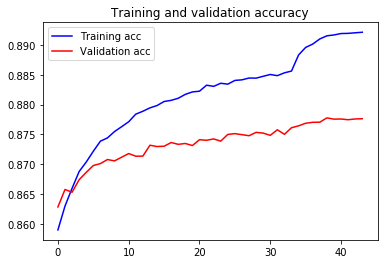

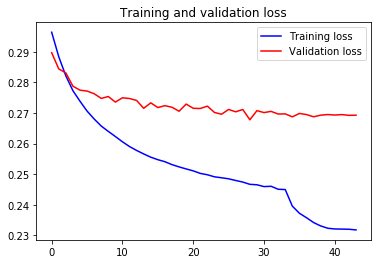

In [235]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
plt.plot(acc, 'b', label='Training acc')
plt.plot(val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

ROC curves
https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

In [238]:
from sklearn.metrics import roc_curve
y_pred = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_keras = y_pred.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(x_train, y_train)

y_pred_rf = rf.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

359388/359388 [==============================] - 27s 77us/step


C:\Users\Lingshu\.conda\envs\my_env\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


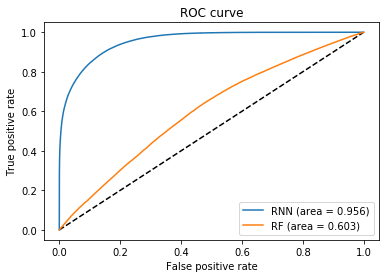

In [239]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='RNN (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig("neg_exp_lstm2.png")
plt.show()


## Predict tweets data

In [10]:
from keras.models import load_model
model = load_model("model_political_affiliation_w2v_2lstm_maxpool.h5")

In [11]:
## open tweets data
#df_tweets = pd.read_csv('C:/R_work/coronavirus/data/covid_users20tweets_usa_jan24-mar20_21pm-23pm_onesixth_5.csv', encoding =DATASET_ENCODING)
#df.iloc[0:5] = df.head(5)
df_tweets = pd.read_csv('C:/R_work/coronavirus/data/china_aid/china_aid_us_3-4_users_tweets.csv', encoding =DATASET_ENCODING)
print(df_tweets.head(5))


     user_id             status_id           created_at screen_name  \
0  x22679832  x1246531096386457602  2020-04-04 20:12:27      Linora   
1  x22679832  x1246530919441272832  2020-04-04 20:11:45      Linora   
2  x22679832  x1246530162386186245  2020-04-04 20:08:44      Linora   
3  x22679832  x1246530084703526914  2020-04-04 20:08:26      Linora   
4  x22679832  x1246529890293252096  2020-04-04 20:07:39      Linora   

                                                text  
0  Our new leader is @Keir_Starmer the architect ...  
1  You are very being lied to. \n\nThis controver...  
2  Capitalism means I get charged $125 to cancel ...  
3  Now #Germany, #France and #Canada know what it...  
4  Please please does anyone have any or know any...  


In [12]:
## remove https
df_tweets.text = df_tweets.text.apply(lambda x: preprocess(x))

In [13]:
print(df_tweets.head(5))
tweets_text = pad_sequences(tokenizer.texts_to_sequences(df_tweets.text), maxlen=80)

     user_id             status_id           created_at screen_name  \
0  x22679832  x1246531096386457602  2020-04-04 20:12:27      Linora   
1  x22679832  x1246530919441272832  2020-04-04 20:11:45      Linora   
2  x22679832  x1246530162386186245  2020-04-04 20:08:44      Linora   
3  x22679832  x1246530084703526914  2020-04-04 20:08:26      Linora   
4  x22679832  x1246529890293252096  2020-04-04 20:07:39      Linora   

                                                text  
0  our new leader is @ keir_starmer the architect...  
1  you are very being lied to. \n\nthis controver...  
2  capitalism means i get charged $125 to cancel ...  
3  now # germany, # france and # canada know what...  
4  please please does anyone have any or know any...  


In [14]:
%%time
tweets_pred = model.predict(tweets_text)

Wall time: 22min 56s


In [15]:
print(tweets_pred[1:5])
df_tweets_pred = pd.DataFrame(data=tweets_pred)
df_tweets_pred.columns = ['party']
#df_tweets_pred.to_csv('C:/R_work/coronavirus/data/covid_users20tweets_usa_jan24-mar20_21pm-23pm_onesixth_partypred_5.csv', index = False)

[[0.59190226]
 [0.00194884]
 [0.35679352]
 [0.7392552 ]]


In [16]:
df_tweets = pd.concat([df_tweets, df_tweets_pred], axis=1)
list(df_tweets.columns) 

['user_id', 'status_id', 'created_at', 'screen_name', 'text', 'party']

In [17]:
df_tweets['word_counts'] = df_tweets.text.apply(lambda x: len(str(x).split()))

In [18]:
user_sent = df_tweets.groupby('user_id')['party'].mean()
user_sent = pd.DataFrame(user_sent).reset_index()
user_sent = user_sent.rename(columns = {'party': 'user_party'})

In [19]:
df_tweets = df_tweets.merge(user_sent, how = 'left', on = 'user_id')

In [20]:
df_tweets.head()

,user_id,status_id,created_at,screen_name,text,party,word_counts,user_party
0,x22679832,x1246531096386457602,2020-04-04 20:12:27,Linora,our new leader is @ keir_starmer the architect...,0.000164,43,0.3659
1,x22679832,x1246530919441272832,2020-04-04 20:11:45,Linora,you are very being lied to. \n\nthis controver...,0.591902,39,0.3659
2,x22679832,x1246530162386186245,2020-04-04 20:08:44,Linora,capitalism means i get charged $125 to cancel ...,0.001949,22,0.3659
3,x22679832,x1246530084703526914,2020-04-04 20:08:26,Linora,"now # germany, # france and # canada know what...",0.356794,28,0.3659
4,x22679832,x1246529890293252096,2020-04-04 20:07:39,Linora,please please does anyone have any or know any...,0.739255,52,0.3659


In [21]:
#df_tweets.to_csv('C:/R_work/coronavirus/data/covid_users20tweets_usa_jan24-mar20_21pm-23pm_onesixth_userparty_5.csv', index = False)
df_tweets.to_csv('C:/R_work/coronavirus/data/china_aid/china_aid_us_3-4_users_tweets_party.csv', index = False)

In [252]:
def decode_sentiment(score, include_neutral=False):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = 0
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = 1

        return label
    else:
        return 0 if score < 0.5 else 1

In [251]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [216]:
print("I hate the rain: ", predict("I hate the rain"), end='\n')
print("I love the music: ", predict("I love the music"), end='\n')
print("i don't know what i'm doing: ", predict("i don't know what i'm doing"), end='\n')
print("I can't be any happier: ", predict("I can't be any happier"))
print("I am not unhappy: ", predict("I am not unhappy"))
print("I could be much happier: ", predict("I could be much happier"))
print("I can't sleep. That voice is repeating in my head: ", predict("I can't sleep. That voice is repeating in my head."))
print("I don't know where I'm going to in my life: ", predict("I don't know where I'm going to in my life"))
print("I don't know her: ", predict("I don't know her"))

I hate the rain:  {'label': 'NEGATIVE', 'score': 0.0048685078509151936, 'elapsed_time': 0.0}
I love the music:  {'label': 'POSITIVE', 'score': 0.9940224289894104, 'elapsed_time': 0.015594005584716797}
i don't know what i'm doing:  {'label': 'NEGATIVE', 'score': 0.04456508904695511, 'elapsed_time': 0.0}
I can't be any happier:  {'label': 'NEGATIVE', 'score': 0.08208955824375153, 'elapsed_time': 0.015620946884155273}
I am not unhappy:  {'label': 'NEGATIVE', 'score': 0.3581579923629761, 'elapsed_time': 0.0}
I could be much happier:  {'label': 'POSITIVE', 'score': 0.9099314212799072, 'elapsed_time': 0.0}
I can't sleep. That voice is repeating in my head:  {'label': 'NEGATIVE', 'score': 0.047460030764341354, 'elapsed_time': 0.015620946884155273}
I don't know where I'm going to in my life:  {'label': 'NEGATIVE', 'score': 0.04947482794523239, 'elapsed_time': 0.0}
I don't know her:  {'label': 'NEGATIVE', 'score': 0.12704114615917206, 'elapsed_time': 0.015621423721313477}


In [57]:
print(y_pred[0])

[9.208918e-06]


Confusion Matrix

In [264]:
df_test['party'] = df_test['party'].map({'D':0, 'R':1})

C:\Users\Lingshu\.conda\envs\my_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [265]:
%%time
#y_pred_1d = y_pred
y_test_1d = list(df_test.party)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in y_pred]

Wall time: 453 ms


In [266]:
y_test_1d[1]

1

In [250]:
from sklearn.metrics import confusion_matrix

In [248]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=22)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=18,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

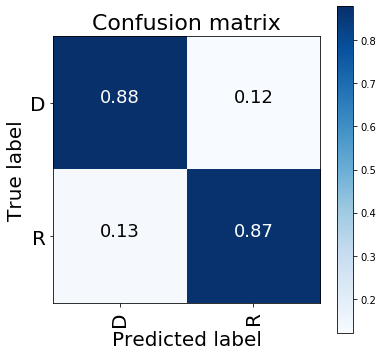

Wall time: 625 ms


In [267]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=df_train.party.unique(), title="Confusion matrix")
plt.show()

In [268]:
cnf_matrix

array([[174265,  24173],
       [ 20636, 140314]], dtype=int64)

In [269]:
174265/(174265+24173)

0.8781836140255395

Classification Report

In [33]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.80      0.80    159494
    POSITIVE       0.80      0.79      0.80    160506

   micro avg       0.80      0.80      0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



Accuracy Score

In [34]:
accuracy_score(y_test_1d, y_pred_1d)

0.79530625

Save model

In [30]:
model.save("model_glove_lstm.h5")
#w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

In [8]:
#read splitted dataset
df_train = pd.read_csv("df_train.csv", encoding ="ISO-8859-1")
df_test = pd.read_csv("df_test.csv", encoding ="ISO-8859-1")
df_train['text'] = df_train['text'].astype(str)
df_test['text'] = df_test['text'].astype(str)

In [9]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())
y_test = y_test.reshape(-1,1)

In [11]:
print(y_test.shape)

(320000, 1)


In [5]:
from keras.models import load_model
model_lstm = load_model("model_LSTM.h5")

from sklearn.metrics import roc_curve
tokenizer = Tokenizer()
x_test_lstm = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=300)
y_pred_lstm = model_lstm.predict(x_test_lstm, verbose=1, batch_size=8000)
y_pred_keras_lstm = y_pred_lstm.ravel()
fpr_keras_lstm, tpr_keras_lstm, thresholds_keras_lstm = roc_curve(y_test, y_pred_keras_lstm)




320000/320000 [==============================] - 5755s 18ms/step


NameError: name 'roc_curve' is not defined

In [10]:
np.save("fpr_lstm.npy", fpr_keras_lstm)
np.save("tpr_lstm.npy", tpr_keras_lstm)

In [40]:
from keras.models import load_model
model_cnnrnn = load_model("model_cnn&rnn.h5")

from sklearn.metrics import roc_curve
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)
x_test_cnnrnn = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=56)
y_pred_cnnrnn = model_cnnrnn.predict(x_test_cnnrnn, verbose=1, batch_size=8000)
y_pred_keras_cnnrnn = y_pred_cnnrnn.ravel()


fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras_cnnrnn)

#np.save("fpr_sqcnn.npy", fpr_keras_sqcnn)
#np.save("tpr_sqcnn.npy", tpr_keras_sqcnn)

320000/320000 [==============================] - 237s 739us/step


In [22]:
y_pred_keras = y_pred_cnnrnn.ravel()

In [44]:
print(fpr_keras_sqcnn.shape)

(113124,)


In [43]:
from keras.models import load_model
model_sqcnn = load_model("model_sequentialCNN.h5")

from sklearn.metrics import roc_curve
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)
x_test_sqcnn = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=300)
y_pred_sqcnn = model_sqcnn.predict(x_test_sqcnn, verbose=1, batch_size=8000)
y_pred_keras_sqcnn = y_pred_sqcnn.ravel()


fpr_keras_sqcnn, tpr_keras_sqcnn, thresholds_keras_sqcnn = roc_curve(y_test, y_pred_keras_sqcnn)

np.save("fpr_sqcnn.npy", fpr_keras_sqcnn)
np.save("tpr_sqcnn.npy", tpr_keras_sqcnn)

320000/320000 [==============================] - 237s 740us/step


In [ ]:
from keras.models import load_model
model_textcnn = load_model("model_textcnn2.h5")

from sklearn.metrics import roc_curve
tokenizer = Tokenizer()
x_test_textcnn = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=300)
y_pred_textcnn = model_textcnn.predict(x_test_textcnn, verbose=1, batch_size=8000)
y_pred_keras_textcnn = y_pred_textcnn.ravel()


fpr_keras_textcnn, tpr_keras_textcnn, thresholds_keras_textcnn = roc_curve(y_test, y_pred_keras_textcnn)

np.save("fpr_textcnn.npy", fpr_keras_textcnn)
np.save("tpr_textcnn.npy", tpr_keras_textcnn)

Instructions for updating:
Colocations handled automatically by placer.


2019-05-14 23:00:25,408 : WARNING : From C:\Users\lings\.conda\envs\sentiment\lib\site-packages\tensorflow\python\framework\op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2019-05-14 23:00:26,089 : WARNING : From C:\Users\lings\.conda\envs\sentiment\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


2019-05-14 23:00:27,527 : WARNING : From C:\Users\lings\.conda\envs\sentiment\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


In [49]:
fpr_keras_cnnrnn = np.load("./fprtpr/fpr_cnnrnn.npy")
tpr_keras_cnnrnn = np.load("./fprtpr/tpr_cnnrnn.npy")

fpr_keras_lstm = np.load("./fprtpr/fpr_lstm.npy")
tpr_keras_lstm = np.load("./fprtpr/tpr_lstm.npy")

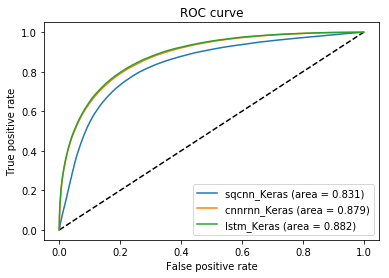

In [51]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
auc_keras_sqcnn = auc(fpr_keras_sqcnn, tpr_keras_sqcnn)
auc_keras_cnnrnn = auc(fpr_keras_cnnrnn, tpr_keras_cnnrnn)
auc_keras_lstm = auc(fpr_keras_lstm, tpr_keras_lstm)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_sqcnn, tpr_keras_sqcnn, label='sqcnn_Keras (area = {:.3f})'.format(auc_keras_sqcnn))
plt.plot(fpr_keras_cnnrnn, tpr_keras_cnnrnn, label='cnnrnn_Keras (area = {:.3f})'.format(auc_keras_cnnrnn))
plt.plot(fpr_keras_lstm, tpr_keras_lstm, label='lstm_Keras (area = {:.3f})'.format(auc_keras_lstm))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()